In [33]:
# Authors: Jeroen BUil
# License: BSD-3-Clause

# 2. Build Models

### About:
This notebook does:
- Feature Extraction:
    - Further processing of the data to get it in a format ready for model training
- Modeling:
    - Build CNN model => high performing! =)
- Evaluation:
    - Training performance over epochs
    - Confusion Matrix
    - ROC + Prec-Recall-Curves


## Prequisistes
1_Exploratory_Data_Analysis notebook must be run before working this notebook to work.
Essential file(s) are created in the subsequent steps

**Note: This notebook must be run for the 3_XAI notebook to work**: Essential file(s) are created in the subsequent steps.

# Init

In [34]:
# for the first time running this notebook this needs to be set to True
# For later runs it is recommended to set to False, as this process can take a few min.
save_spectograms_as_images = True

# Automatically the model that is trained at the end of this notebook? => recommende for the first time running.
save_model = True

In [35]:
import os
import sys
import glob as glob

import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
from tqdm.notebook import tqdm

from IPython.display import clear_output
from PIL import Image, ImageChops
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

# Force add module to sys path as it is sometimes not recognised
module_path = os.path.abspath(os.path.join("..")) + "/deegtal_coding_task"
if module_path not in sys.path:
    sys.path.append(module_path)
from config import *

from model_architecture import SimpleCNN

# Load preprocessed EEG recordings

In [36]:
preprocessed_eeg_dict_file = "preprocessed_eeg_dict.pkl"
preprocessed_eeg_dict_file_path = INTERIM_DATA_DIR / preprocessed_eeg_dict_file


if Path.exists(preprocessed_eeg_dict_file_path):
    print("Loading preprocessed_eeg_dict")
    with open(preprocessed_eeg_dict_file_path, "rb") as pkl_rb_obj:
        preprocessed_eeg_dict = pickle.load(pkl_rb_obj)
else:
    ValueError("No file found at the following path: {preprocessed_eeg_dict_file_path}")

print("Done")

Loading preprocessed_eeg_dict
Done


In [37]:
recording = preprocessed_eeg_dict[0]
recording["raw"]

<RawEDF | 1_1.edf, 30 x 356250 (1425.0 s), ~81.6 MB, data loaded>

# Generate Features

The following cell further processes each preprocessed EEG recording and extracts features from them:
The features are the images of the spectogram of the selected channels (no still 1 channel)

In [38]:
def trim_whitespace(im: Image) -> Image:
    bg = Image.new(im.mode, im.size, im.getpixel((0, 0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

In [39]:
def axesimage_to_pil_image(axesimage) -> Image:
    """Perform this cumbersome dance below to convert spect which is an AxesImage to a PIL Image

    ARG:
    - axesImage [AxesImage]: E.g. a spectogram

    RETURN:
    - PIL.Image

    """
    # Retrieve the data array from `spect`
    data = axesimage.get_array()

    # Ensure the data is of a compatible numeric type
    data = data.astype(np.float32)  # Convert if necessary

    # Plot the retrieved data in a new figure
    fig, ax = plt.subplots()
    ax.imshow(data, cmap="viridis")
    plt.show()

    # Convert the figure to a PIL Image
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Convert the rendering to an array and then to a PIL Image
    img_array = np.frombuffer(canvas.tostring_rgb(), dtype="uint8")
    img_array = img_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    pil_img = Image.fromarray(img_array)

    # Trim white space around the image
    pil_img = trim_whitespace(pil_img)

    # Close the figure
    plt.close(fig)

    return pil_img

Processing (make take a few min in total) - Group: 2, Recording: 5, iwindow: 71, ichannel: 0:


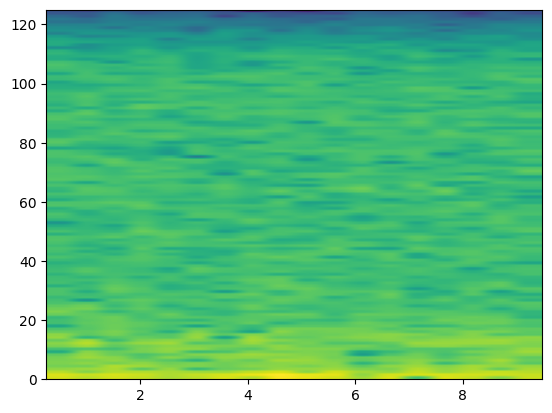

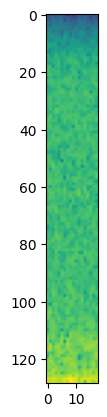

 Recording: 100%|██████████| 10/10 [01:57<00:00, 11.80s/it]

Done


In [40]:
# User parameters: (recommended to leave default)
recording_start = 10 * 60  # [s] start 10 min in the recording to avoid startup noise
recording_end = 15 * 60  # [s] end 15 min in the recording to avoid end recording noise
win_len = 10  # [s] window length
stepsize = 4  # [s] how far each window is spaced apart. Note: if stepsize < win_len, then there is overlap between the windows!

n_windows = int(
    np.floor((((recording_end - recording_start) - win_len) / stepsize))
)  # the maximum amount of windows that can be fitted in the recordingstart-end period
n_channels = 1  # len(mne.pick_types(raw.info, eeg=True, exclude='bads')) # currently

mne.set_log_level("WARNING")  # disable verbose output from MNE

n_recordings = len(preprocessed_eeg_dict)

if save_spectograms_as_images == True:
    for iRecord in tqdm(range(n_recordings), desc=" Recording", position=tqdm._get_free_pos()):
        recording_dict = preprocessed_eeg_dict[iRecord]
        raw = recording_dict["raw"].copy()
        group = recording_dict["Group"]
        recording = recording_dict["Recording"]

        Fs = raw.info["sfreq"]

        # Crop windows of data somewhere in the middle of the recording to avoid recording start and end noise
        raw.crop(recording_start, recording_end)
        for iwindow in range(n_windows):
            # Loop over recording and cut segements out of it with overlap
            window_start = iwindow * stepsize
            window_end = window_start + win_len
            window_copy = raw.copy().crop(window_start, window_end)

            # Copy data channels and time vector
            picks = mne.pick_types(window_copy.info, eeg=True, exclude="bads")
            data, times = window_copy[picks, :]

            # Loop over channels to calc spectogram for each
            spectogram_list = []  # store spectograms in here

            for ichannel in range(n_channels):
                # Note: only supports one channel right now, for multiple channels the spectograms need to be concatenated into a single bigger image
                clear_output()
                print(
                    f"Processing (make take a few min in total) - Group: {group}, Recording: {recording}, iwindow: {iwindow}, ichannel: {ichannel}:"
                )
                x = data[ichannel]
                # Create spectogram
                spectogram, freqs, t, im = plt.specgram(x, Fs=Fs)

                # Convert spectogram AxesImage to a PIL image
                pil_img = axesimage_to_pil_image(axesimage=im)

                # Create group folder if it doesn't exist to save images
                group_im_path = INTERIM_DATA_DIR / f"Group{group}_Spectograms"
                Path(group_im_path).mkdir(parents=True, exist_ok=True)

                # Store pil image to folder
                img_path = (
                    group_im_path
                    / f"group{group}_recording{recording}_channel{ichannel+1}_window{iwindow+1}.png"
                )
                pil_img.save(img_path)

print("Done")

# Build CNN Classifier

In [41]:
# Define transformations for the images
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),  # Resize images to a common size
        transforms.ToTensor(),  # Convert images to PyTorch tensors
    ]
)

# Load the dataset
dataset = datasets.ImageFolder(root=INTERIM_DATA_DIR, transform=transform)

# Split the dataset into training and test sets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
# Instantiate the model, define the loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN()  # Loaded from deegtal_coding_task/model_architecture.py
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
n_epochs = 100
train_accuracies = []
test_accuracies = []
loss_values = []


for epoch in range(n_epochs):
    # Training phase
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    # Store loss values (for plotting)
    loss_values.append(loss_values)

    # Calc train accuracy
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Testing phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Calc test accuracy
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)

    print(
        f"Epoch [{epoch+1}/{n_epochs}],\tLoss: {running_loss / len(train_loader):.4f},\tTrain Accuracy: {train_accuracy:.2f}%,\tTest Accuracy: {test_accuracy:.2f}%"
    )

Epoch [1/100],	Loss: 1.5551,	Train Accuracy: 48.61%,	Test Accuracy: 48.61%
Epoch [2/100],	Loss: 1.4034,	Train Accuracy: 46.53%,	Test Accuracy: 48.61%
Epoch [3/100],	Loss: 1.3872,	Train Accuracy: 48.78%,	Test Accuracy: 63.19%
Epoch [4/100],	Loss: 1.3743,	Train Accuracy: 56.60%,	Test Accuracy: 56.25%
Epoch [5/100],	Loss: 1.3499,	Train Accuracy: 58.33%,	Test Accuracy: 63.89%
Epoch [6/100],	Loss: 1.3338,	Train Accuracy: 55.21%,	Test Accuracy: 67.36%
Epoch [7/100],	Loss: 1.2559,	Train Accuracy: 64.76%,	Test Accuracy: 63.19%
Epoch [8/100],	Loss: 1.2349,	Train Accuracy: 64.06%,	Test Accuracy: 68.06%
Epoch [9/100],	Loss: 1.1519,	Train Accuracy: 70.31%,	Test Accuracy: 70.83%
Epoch [10/100],	Loss: 1.1028,	Train Accuracy: 69.44%,	Test Accuracy: 70.14%
Epoch [11/100],	Loss: 1.1480,	Train Accuracy: 67.53%,	Test Accuracy: 71.53%
Epoch [12/100],	Loss: 1.0562,	Train Accuracy: 72.05%,	Test Accuracy: 73.61%
Epoch [13/100],	Loss: 0.9596,	Train Accuracy: 74.48%,	Test Accuracy: 79.86%
Epoch [14/100],	Loss:

# Evaluation

## Plot Training performance

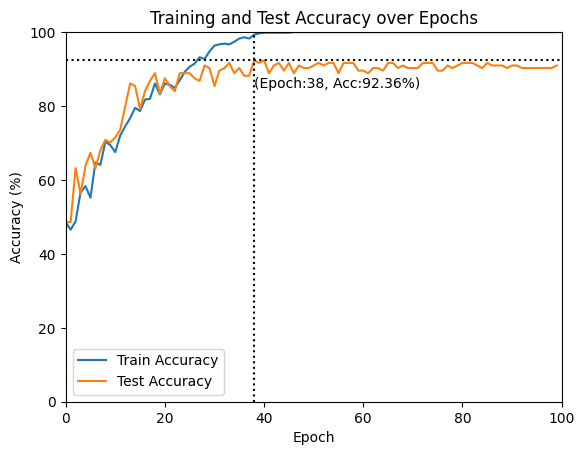

In [52]:
# Plotting training and test accuracies
x = range(0, n_epochs)
x = range(0, n_epochs)
xmax = x[np.argmax(test_accuracies)]
ymax = max(test_accuracies)

plt.plot(x, train_accuracies, label="Train Accuracy")
plt.plot(x, test_accuracies, label="Test Accuracy")

plt.axhline(ymax, ls=":", c="k")
plt.axvline(xmax, ls=":", c="k")
plt.text(xmax, ymax * 0.92, f"(Epoch:{round(xmax,2)}, Acc:{round(ymax,2)}%)")

plt.ylim(0, 100)
plt.xlim(0, n_epochs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy over Epochs")
plt.legend()

plt.show()

# Confusion Matrix

Accuracy: 90.97% 	 F1-score: 90.65%


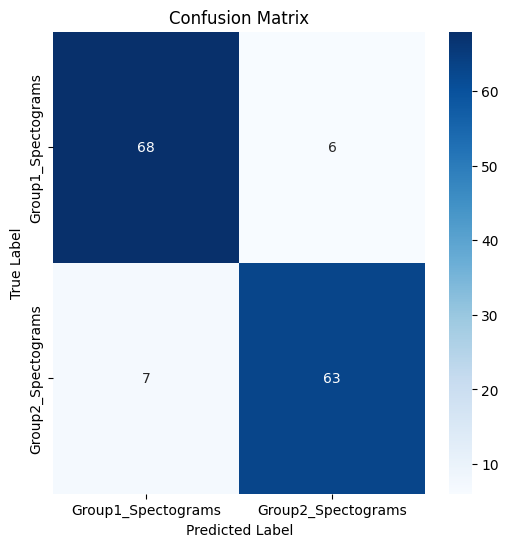

In [49]:
# Confusion Matrix
model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation for inference
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}% \t F1-score: {f1 * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=dataset.classes,
    yticklabels=dataset.classes,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC + Precision-Recall Curves

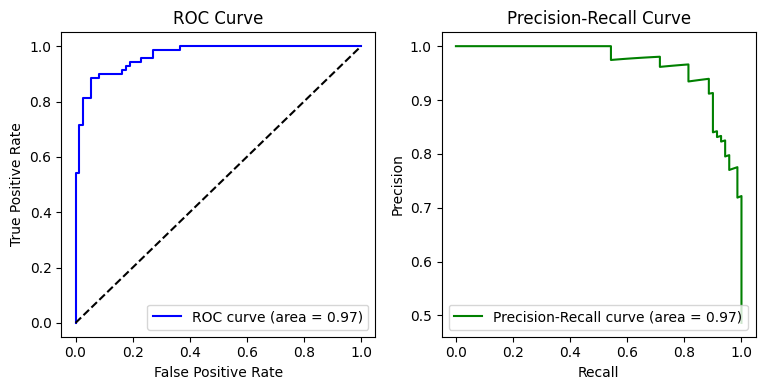

In [50]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Ensure model is in evaluation mode
model.eval()

# Initialize lists to store true labels and predicted probabilities
all_labels = []
all_probs = []

# Run through the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass and get predictions
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Get probability for class 1

        # Append to lists
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays for compatibility with sklearn
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and AUC
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

# Plotting ROC and Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# ROC Curve
axes[0].plot(fpr, tpr, color="b", label=f"ROC curve (area = {roc_auc:.2f})")
axes[0].plot([0, 1], [0, 1], "k--")  # Diagonal line for random guessing
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend(loc="lower right")

# Precision-Recall Curve
axes[1].plot(recall, precision, color="g", label=f"Precision-Recall curve (area = {pr_auc:.2f})")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.show()

# Save Model

In [54]:
if save_model == True:
    curr_dir = os.path.abspath("")

    model_path = Path(curr_dir).parent.resolve() / "models" / "CNN_Model.pkl"


    print(f"Saving model at {model_path}")

    torch.save(model.state_dict(), model_path)

    print("Done")

Saving model at D:\Files\Projects\Code\deegtal_coding_task\models\CNN_Model.pkl
Done


In [29]:
# # Load model
# curr_dir = os.path.abspath("")
# model_path = Path(curr_dir).parent.resolve() / "models" / "CNN_Model.pkl"

# model = SimpleCNN()
# model.load_state_dict(torch.load(model_path, weights_only=True))
# model.eval()